In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
%matplotlib inline

In [2]:
### SET UP THE SIMULATOR ###

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShear(pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb')), 
                                                           lmin = 10, lmax = 3000, n_ell_bins = 10, sigma_e = 0.3, 
                                                           nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args):
    return CosmicShearSimulator.simulate(theta, seed)
simulator_args = None

In [3]:
### SET UP THE PRIOR ###

# Define the priors parameters
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Prior
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Expected support of Wishart likelihood (fiducial inverse power spectrum)
C = CosmicShearSimulator.power_spectrum(theta_fiducial)
Cinv = np.array([np.linalg.inv(C[l,:,:]) for l in range(CosmicShearSimulator.n_ell_bins)])

# Degrees of freedom (effective number of modes per band power)
nl = CosmicShearSimulator.nl

# Calculate derivatives of the expected power spectrum
h = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = CosmicShearSimulator.compute_derivatives(theta_fiducial, h)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Wishart(theta_fiducial, nl, Cinv, dCdt, prior_mean=prior_mean, prior_covariance=prior_covariance)

# Pull out Fisher matrix inverse
Finv = Compressor.Finv

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args = None

In [5]:
### LOAD IN THE DATA VECTOR ###
data = compressor(simulator(theta_fiducial, 42, simulator_args), compressor_args)

In [7]:
# Create the DELFI object
DelfiMAF = delfi.Delfi(data, prior, MAF, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results/")

Generating fisher pre-training data...
Training the neural density estimator...
Epoch 00000, Train_loss: 5.6201, Val_loss: 5.6067
Epoch 00001, Train_loss: 5.1039, Val_loss: 5.0818
Epoch 00002, Train_loss: 4.9470, Val_loss: 4.9330
Epoch 00003, Train_loss: 4.6698, Val_loss: 4.6493
Epoch 00004, Train_loss: 4.5871, Val_loss: 4.5768
Epoch 00005, Train_loss: 4.4220, Val_loss: 4.4232
Epoch 00006, Train_loss: 4.6519, Val_loss: 4.6266
Epoch 00007, Train_loss: 5.1128, Val_loss: 5.0949
Epoch 00008, Train_loss: 4.8404, Val_loss: 4.8394
Epoch 00009, Train_loss: 4.5288, Val_loss: 4.5375
Epoch 00010, Train_loss: 4.3418, Val_loss: 4.3407
Epoch 00011, Train_loss: 4.3913, Val_loss: 4.3796
Epoch 00012, Train_loss: 4.7037, Val_loss: 4.6896
Epoch 00013, Train_loss: 5.3407, Val_loss: 5.3304
Epoch 00014, Train_loss: 4.6843, Val_loss: 4.6797
Epoch 00015, Train_loss: 4.9445, Val_loss: 4.9207
Epoch 00016, Train_loss: 4.6204, Val_loss: 4.6164
Epoch 00017, Train_loss: 4.5086, Val_loss: 4.5011
Epoch 00018, Train_l

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Done.
Sampling approximate posterior...
Done.
Plotting the posterior (1D and 2D marginals)...
Saving simulators/cosmic_shear/results/fisher_pretrain_post.pdf


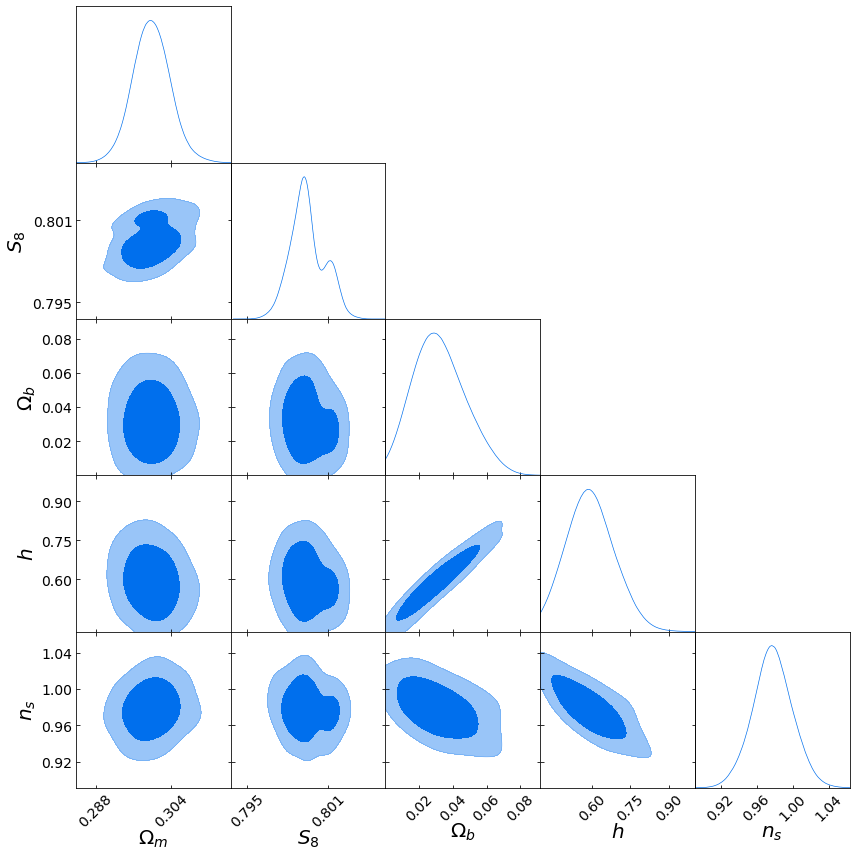

In [9]:
# Do the Fisher pre-training
DelfiMAF.fisher_pretraining(200000, prior, epochs=500, patience=100)

Running initial 500 sims...
Done.
Epoch 00000, Train_loss: 9.9649, Val_loss: 11.5391
Epoch 00001, Train_loss: 8.1198, Val_loss: 8.1783
Epoch 00002, Train_loss: 7.7719, Val_loss: 7.9475
Epoch 00003, Train_loss: 7.3087, Val_loss: 7.5112
Epoch 00004, Train_loss: 6.9746, Val_loss: 7.1557
Epoch 00005, Train_loss: 6.7177, Val_loss: 7.0730
Epoch 00006, Train_loss: 6.4717, Val_loss: 6.8569
Epoch 00007, Train_loss: 6.3615, Val_loss: 6.8148
Epoch 00008, Train_loss: 6.2468, Val_loss: 6.7733
Epoch 00009, Train_loss: 6.1455, Val_loss: 6.7627
Epoch 00010, Train_loss: 6.0829, Val_loss: 6.8016
Epoch 00011, Train_loss: 6.0564, Val_loss: 6.7612
Epoch 00012, Train_loss: 5.9927, Val_loss: 6.8344
Epoch 00013, Train_loss: 5.8703, Val_loss: 6.6207
Epoch 00014, Train_loss: 5.8620, Val_loss: 6.6751
Epoch 00015, Train_loss: 5.7745, Val_loss: 6.6062
Epoch 00016, Train_loss: 5.7373, Val_loss: 6.6019
Epoch 00017, Train_loss: 5.6874, Val_loss: 6.6351
Epoch 00018, Train_loss: 5.6190, Val_loss: 6.5368
Epoch 00019, Tr

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_0.pdf


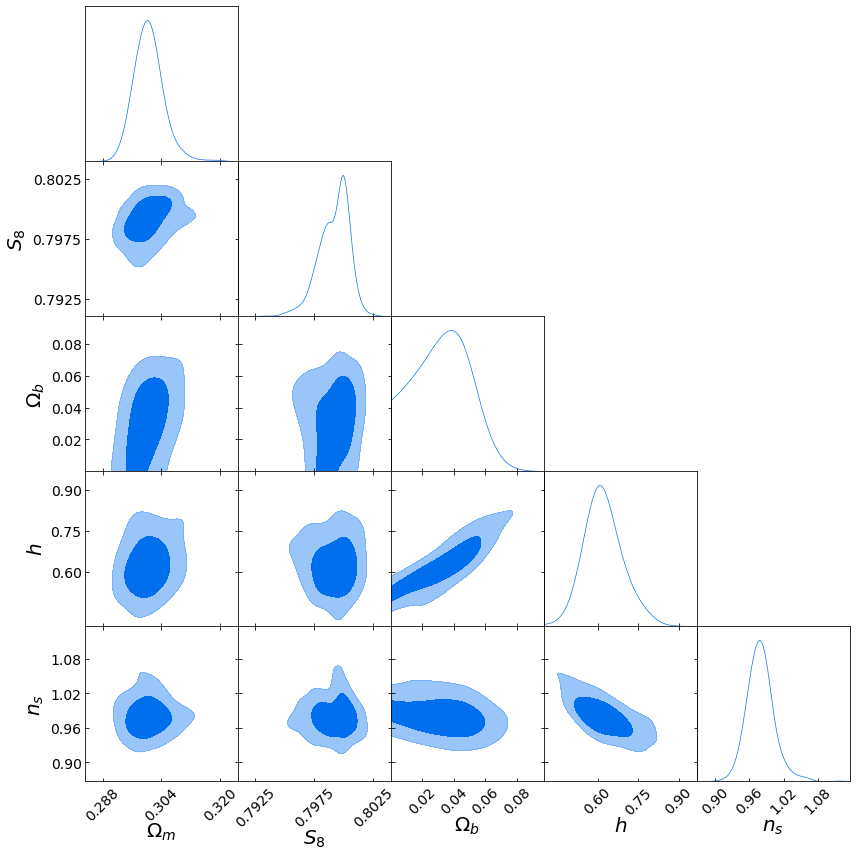

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 4.7895, Val_loss: 4.8362
Epoch 00001, Train_loss: 4.6303, Val_loss: 4.5276
Epoch 00002, Train_loss: 4.5645, Val_loss: 4.4307
Epoch 00003, Train_loss: 4.4723, Val_loss: 4.3649
Epoch 00004, Train_loss: 4.4489, Val_loss: 4.3112
Epoch 00005, Train_loss: 4.3728, Val_loss: 4.2907
Epoch 00006, Train_loss: 4.3366, Val_loss: 4.2603
Epoch 00007, Train_loss: 4.3017, Val_loss: 4.1984
Epoch 00008, Train_loss: 4.2856, Val_loss: 4.2432
Epoch 00009, Train_loss: 4.2621, Val_loss: 4.2189
Epoch 00010, Train_loss: 4.2238, Val_loss: 4.2067
Epoch 00011, Train_loss: 4.2374, Val_loss: 4.2455
Epoch 00012, Train_loss: 4.1976, Val_loss: 4.2119
Epoch 00013, Train_loss: 4.1477, Val_loss: 4.2698
Epoch 00014, Train_loss: 4.1684, Val_loss: 4.3242
Epoch 00015, Train_loss: 4.1108, Val_loss: 4.2698
Epoch 00016, Train_loss: 4.1269, Val_loss: 4.2763
Epoch 00017, Train_loss: 4.1024, Val_loss: 4.3458
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_1.pdf


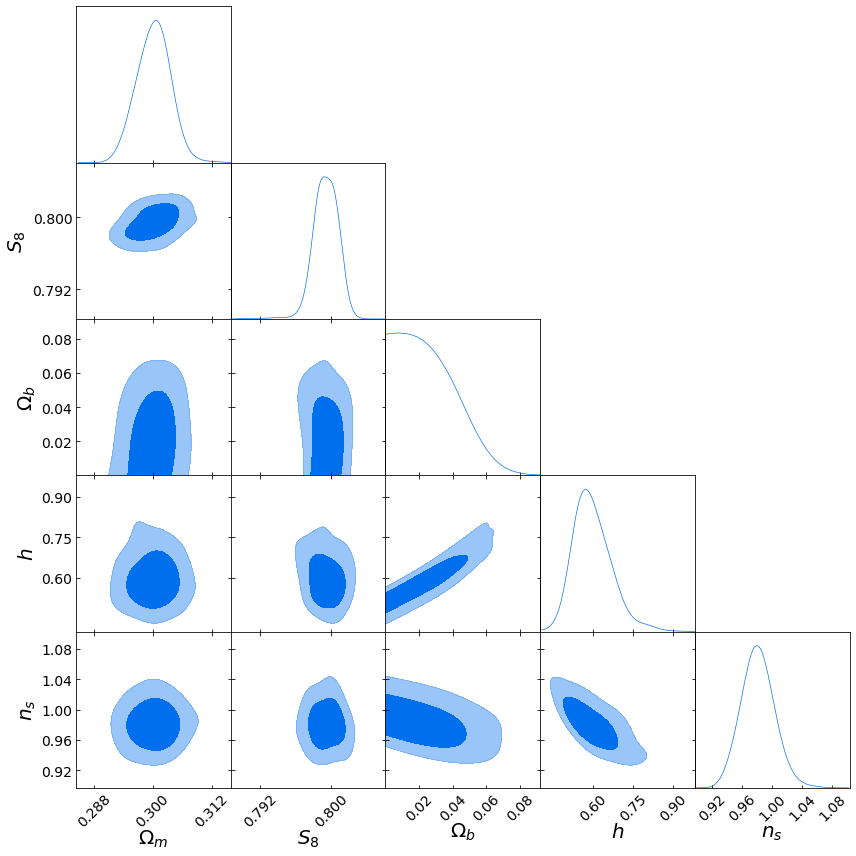

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


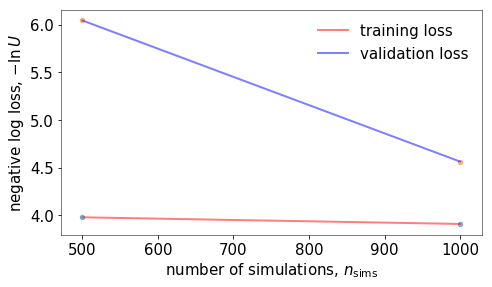

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 4.3920, Val_loss: 4.4850
Epoch 00001, Train_loss: 4.3773, Val_loss: 4.5655
Epoch 00002, Train_loss: 4.3723, Val_loss: 4.5466
Epoch 00003, Train_loss: 4.2954, Val_loss: 4.5083
Epoch 00004, Train_loss: 4.2469, Val_loss: 4.4922
Epoch 00005, Train_loss: 4.1763, Val_loss: 4.4666
Epoch 00006, Train_loss: 4.1858, Val_loss: 4.4856
Epoch 00007, Train_loss: 4.1480, Val_loss: 4.4895
Epoch 00008, Train_loss: 4.1374, Val_loss: 4.4896
Epoch 00009, Train_loss: 4.1245, Val_loss: 4.5269
Epoch 00010, Train_loss: 4.0898, Val_loss: 4.4772
Epoch 00011, Train_loss: 4.2548, Val_loss: 4.6624
Epoch 00012, Train_loss: 4.0815, Val_loss: 4.5611
Epoch 00013, Train_loss: 4.0322, Val_loss: 4.5239
Epoch 00014, Train_loss: 3.9989, Val_loss: 4.5067
Epoch 00015, Train_loss: 4.0788, Val_loss: 4.6058
Epoch 00016, Train_loss: 3.9483, Val_loss: 4.4621
Epoch 00017, Train_loss: 3.9733, Val_loss: 4.5667
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_2.pdf


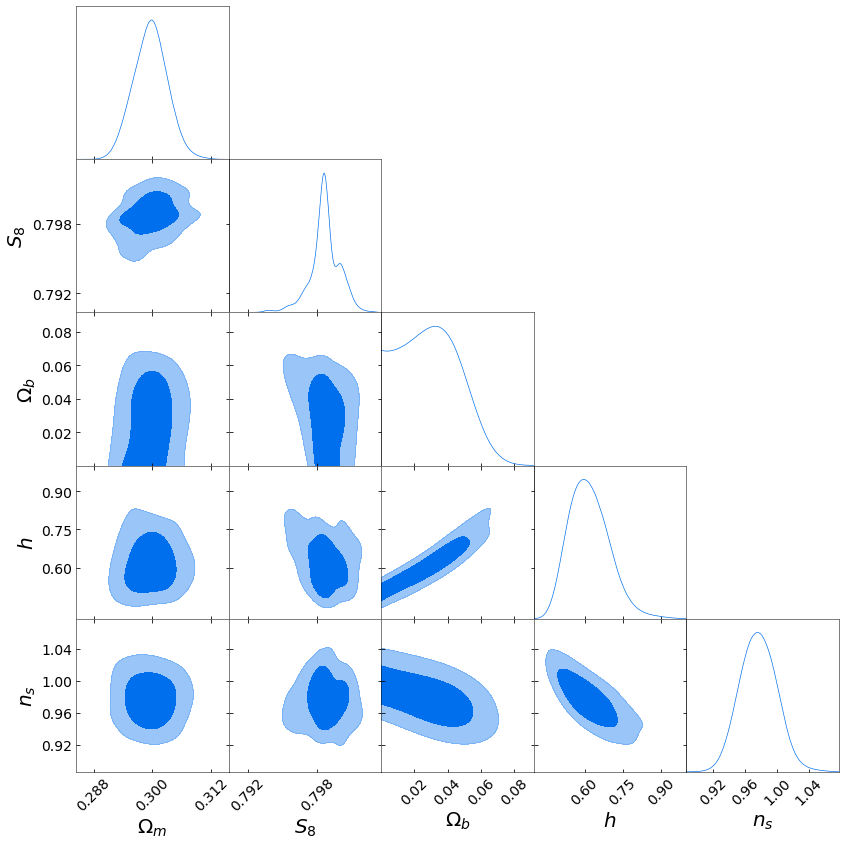

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


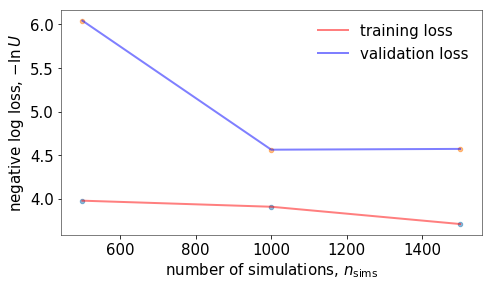

Population 3/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 4.2698, Val_loss: 4.2220
Epoch 00001, Train_loss: 4.2451, Val_loss: 4.2486
Epoch 00002, Train_loss: 4.2416, Val_loss: 4.2614
Epoch 00003, Train_loss: 4.1540, Val_loss: 4.2238
Epoch 00004, Train_loss: 4.1321, Val_loss: 4.1940
Epoch 00005, Train_loss: 4.0977, Val_loss: 4.1267
Epoch 00006, Train_loss: 4.1027, Val_loss: 4.1590
Epoch 00007, Train_loss: 4.0639, Val_loss: 4.1435
Epoch 00008, Train_loss: 4.0508, Val_loss: 4.0751
Epoch 00009, Train_loss: 4.1688, Val_loss: 4.1722
Epoch 00010, Train_loss: 4.1590, Val_loss: 4.1599
Epoch 00011, Train_loss: 3.9896, Val_loss: 4.0909
Epoch 00012, Train_loss: 4.0577, Val_loss: 4.2089
Epoch 00013, Train_loss: 3.9758, Val_loss: 4.0650
Epoch 00014, Train_loss: 3.9737, Val_loss: 4.0977
Epoch 00015, Train_loss: 3.9437, Val_loss: 4.0918
Epoch 00016, Train_loss: 3.9663, Val_loss: 4.1624
Epoch 00017, Train_loss: 3.9654, Val_loss: 4.0876
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_3.pdf


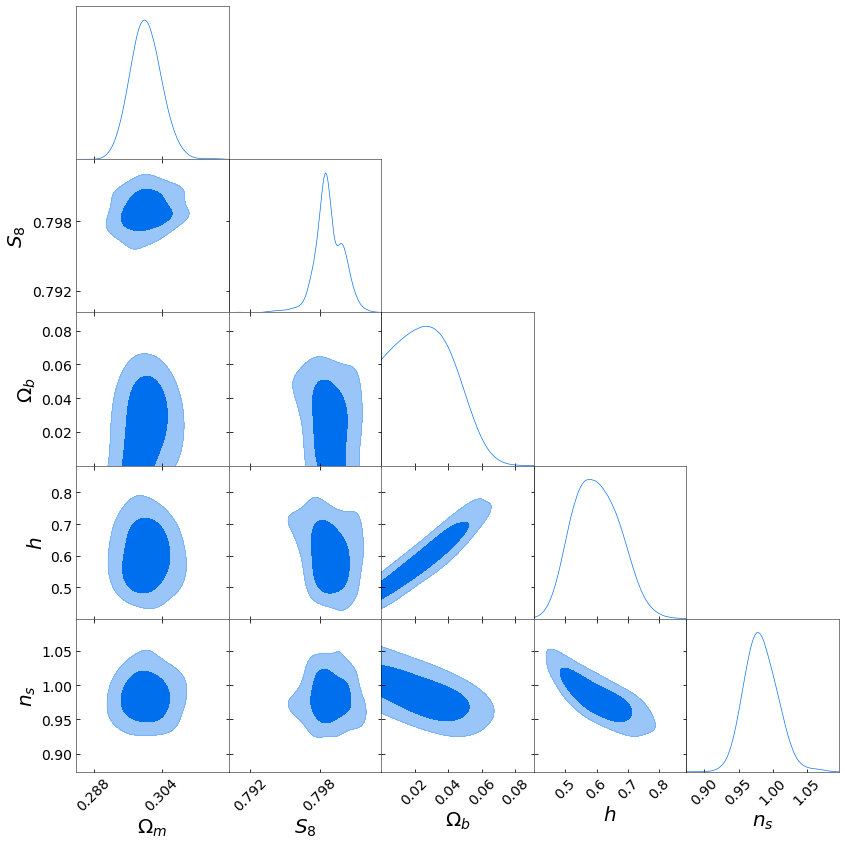

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


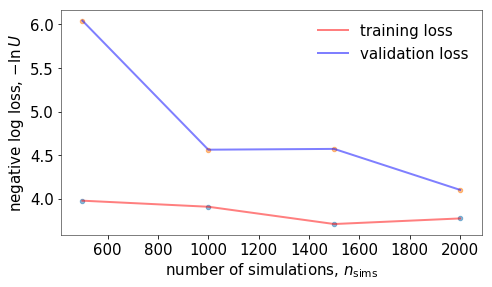

Population 4/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 4.1112, Val_loss: 4.1540
Epoch 00001, Train_loss: 4.1040, Val_loss: 4.1657
Epoch 00002, Train_loss: 4.0452, Val_loss: 4.1500
Epoch 00003, Train_loss: 4.0316, Val_loss: 4.1644
Epoch 00004, Train_loss: 4.0490, Val_loss: 4.1970
Epoch 00005, Train_loss: 4.0251, Val_loss: 4.1956
Epoch 00006, Train_loss: 4.0191, Val_loss: 4.1984
Epoch 00007, Train_loss: 4.0233, Val_loss: 4.2312
Epoch 00008, Train_loss: 4.0614, Val_loss: 4.2639
Epoch 00009, Train_loss: 4.0129, Val_loss: 4.2661
Epoch 00010, Train_loss: 3.9859, Val_loss: 4.2294
Epoch 00011, Train_loss: 3.9442, Val_loss: 4.1960
Epoch 00012, Train_loss: 3.9250, Val_loss: 4.1862
Epoch 00013, Train_loss: 3.9359, Val_loss: 4.2060
Epoch 00014, Train_loss: 3.9151, Val_loss: 4.1852
Epoch 00015, Train_loss: 3.9181, Val_loss: 4.2371
Epoch 00016, Train_loss: 3.8706, Val_loss: 4.1894
Epoch 00017, Train_loss: 3.9374, Val_loss: 4.2939
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_4.pdf


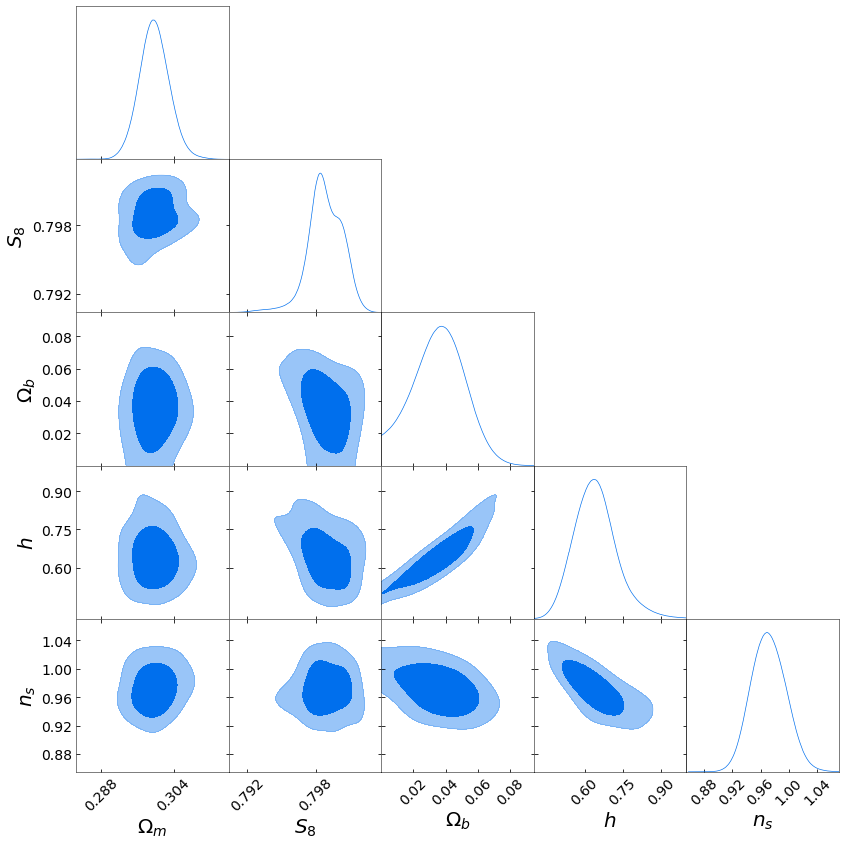

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


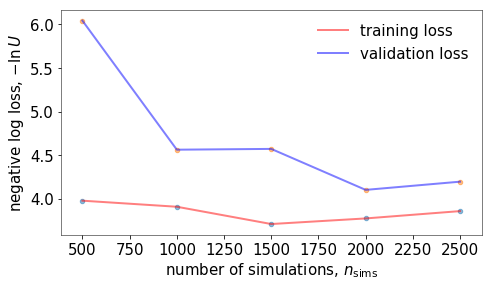

Population 5/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 4.1407, Val_loss: 4.4779
Epoch 00001, Train_loss: 4.1384, Val_loss: 4.5226
Epoch 00002, Train_loss: 4.0957, Val_loss: 4.4799
Epoch 00003, Train_loss: 4.0627, Val_loss: 4.4357
Epoch 00004, Train_loss: 4.0384, Val_loss: 4.4555
Epoch 00005, Train_loss: 4.0237, Val_loss: 4.4351
Epoch 00006, Train_loss: 3.9978, Val_loss: 4.4027
Epoch 00007, Train_loss: 3.9858, Val_loss: 4.4425
Epoch 00008, Train_loss: 3.9900, Val_loss: 4.4660
Epoch 00009, Train_loss: 3.9937, Val_loss: 4.4169
Epoch 00010, Train_loss: 3.9633, Val_loss: 4.4100
Epoch 00011, Train_loss: 3.9711, Val_loss: 4.4414
Epoch 00012, Train_loss: 3.9630, Val_loss: 4.4321
Epoch 00013, Train_loss: 3.9767, Val_loss: 4.4233
Epoch 00014, Train_loss: 3.9125, Val_loss: 4.4387
Epoch 00015, Train_loss: 3.9085, Val_loss: 4.4522
Epoch 00016, Train_loss: 3.9219, Val_loss: 4.4303
Epoch 00017, Train_loss: 3.8984, Val_loss: 4.4620
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_5.pdf


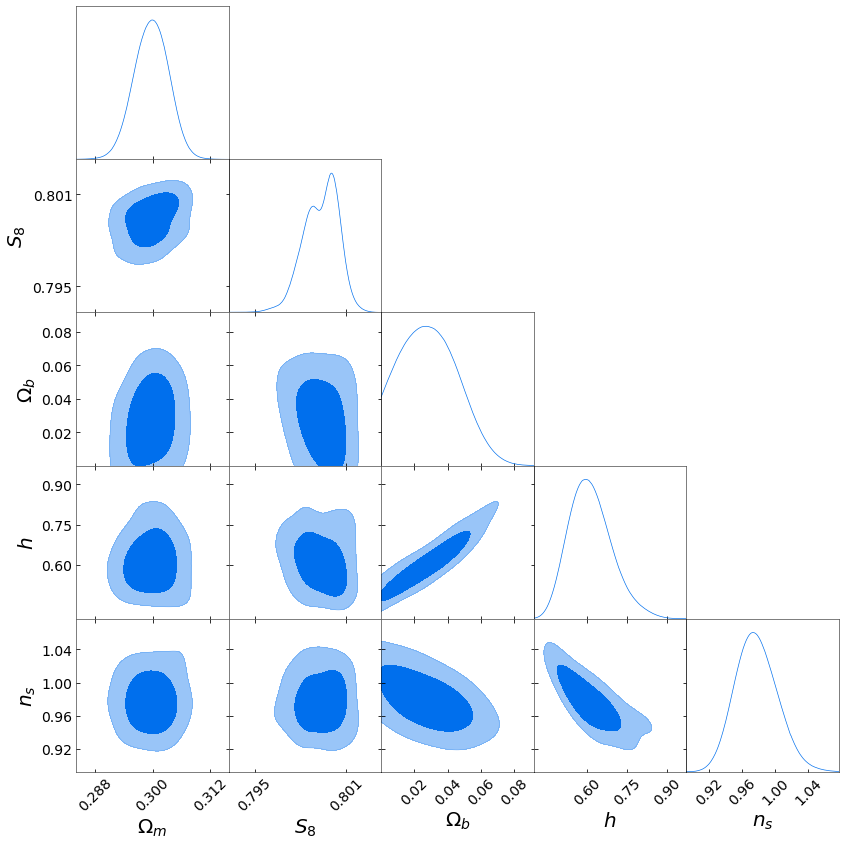

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


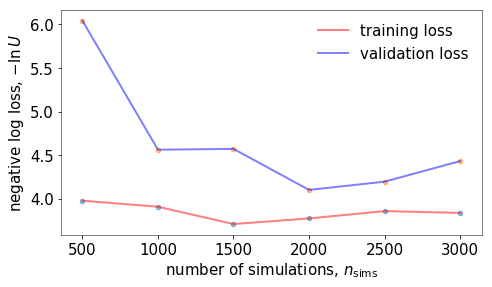

Population 6/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 4.1002, Val_loss: 3.9305
Epoch 00001, Train_loss: 4.1318, Val_loss: 3.9878
Epoch 00002, Train_loss: 4.0526, Val_loss: 3.9429
Epoch 00003, Train_loss: 4.0251, Val_loss: 3.9328
Epoch 00004, Train_loss: 4.0076, Val_loss: 3.9346
Epoch 00005, Train_loss: 3.9968, Val_loss: 3.9312
Epoch 00006, Train_loss: 4.0225, Val_loss: 3.9736
Epoch 00007, Train_loss: 3.9703, Val_loss: 3.9265
Epoch 00008, Train_loss: 3.9715, Val_loss: 3.9397
Epoch 00009, Train_loss: 3.9797, Val_loss: 3.9703
Epoch 00010, Train_loss: 3.9585, Val_loss: 3.9354
Epoch 00011, Train_loss: 3.9414, Val_loss: 3.9515
Epoch 00012, Train_loss: 4.0324, Val_loss: 4.0527
Epoch 00013, Train_loss: 3.9542, Val_loss: 3.9596
Epoch 00014, Train_loss: 3.9163, Val_loss: 3.9318
Epoch 00015, Train_loss: 3.9363, Val_loss: 3.9816
Epoch 00016, Train_loss: 3.9400, Val_loss: 3.9601
Epoch 00017, Train_loss: 3.9521, Val_loss: 3.9804
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results/tmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results/seq_train_post_6.pdf


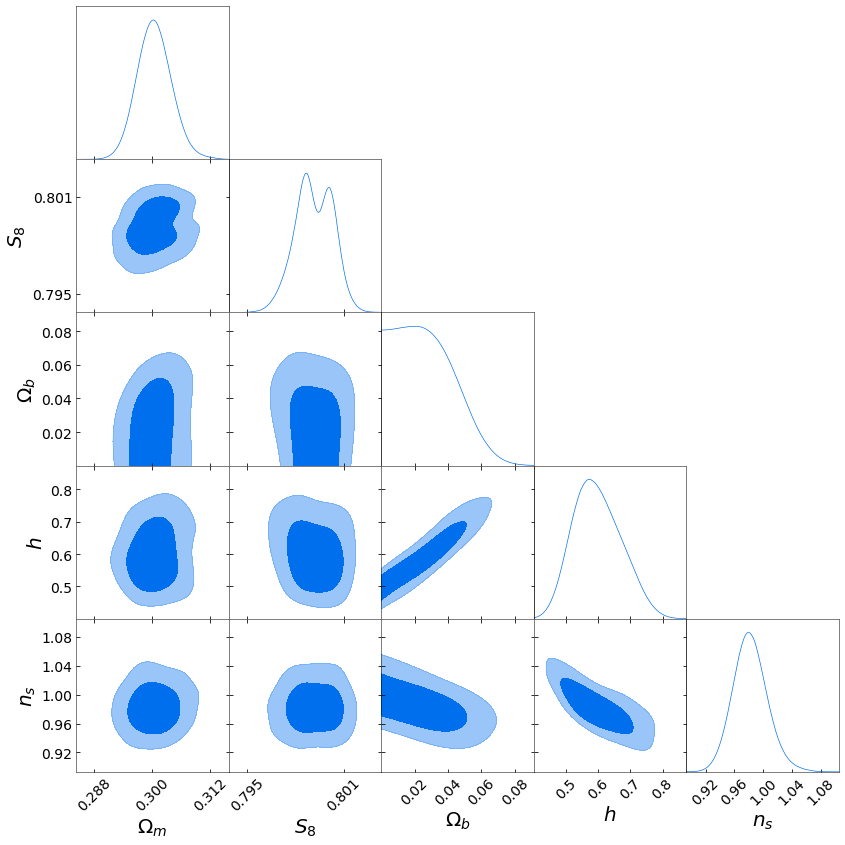

Saving simulators/cosmic_shear/results/seq_train_loss.pdf


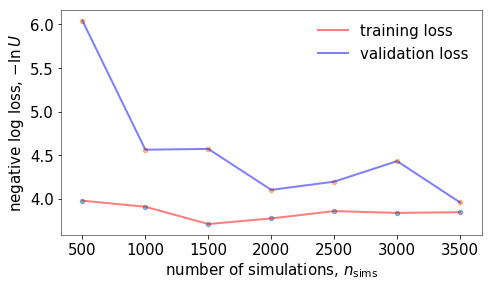

Population 7/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.28862985 0.79914809 0.00155232 0.52208258 0.98718378] (rank 0)


In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
DelfiMAF.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10)

In [ ]:
plt.close()
columnwidth = 18 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 15,
                 'legend.fontsize': 15,
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})

# Trace plot of the training and validation loss as a function of the number of simulations ran
plt.scatter(DelfiMAF.sequential_nsims, DelfiMAF.sequential_training_loss, s = 20, alpha = 0.5)
plt.plot(DelfiMAF.sequential_nsims, DelfiMAF.sequential_training_loss, color = 'red', lw = 2, alpha = 0.5, label = 'training loss')
plt.scatter(DelfiMAF.sequential_nsims, DelfiMAF.sequential_validation_loss, s = 20, alpha = 0.5)
plt.plot(DelfiMAF.sequential_nsims, DelfiMAF.sequential_validation_loss, color = 'blue', lw = 2, alpha = 0.5, label = 'validation loss')


#plt.fill_between(DelfiMAF.sequential_nsims, (DelfiMAF.sequential_validation_loss[-1]-0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), 
#                 (DelfiMAF.sequential_validation_loss[-1]+0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), color = 'grey', alpha = 0.2 )

plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
plt.ylabel(r'negative log loss, $-\mathrm{ln}\,U$')
#plt.savefig('../../paper_II/plots/convergence_fixedII.pdf')
plt.tight_layout()
plt.legend()
plt.show()